In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

sys.path.insert(0, '../kinetic_analysis')
from kinetic_function import (single_track_analysis,
                              generate_track
                             )

In [2]:
path_save = "/home/u2175049/Documents/Code/KineticAnalysis/notebook/figures/"
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/05-Modelling/02-DeltaT/"

In [3]:
prot_aa_size = {
    "32xsuntag": 796,  #768/32=24 , left 28
    "linker": 4,
    "twist": 490,
    "ilp4": 134,
    "snail": 390,
    "very_long_prot":2000, 
}

In [6]:
prot_length = prot_aa_size["32xsuntag"]+prot_aa_size["snail"]
for i in range(100):
    x_global, y_global, y_start_prot = generate_track(prot_length = prot_aa_size["snail"], 
                                                      suntag_length = prot_aa_size["32xsuntag"], 
                                                      nb_suntag=32, 
                                                      fluo_one_suntag=4, 
                                                      translation_rate=24, 
                                                      binding_rate=0.05,
                                                      step = 0.1)
    if i == 0:
        datas = pd.DataFrame({"FRAME":x_global,
                          "MEAN_INTENSITY_CH1":y_global,
                          "TRACK_ID" : i
                             })
    else:
        datas = pd.concat([datas, 
                           pd.DataFrame({"FRAME":x_global,
                          "MEAN_INTENSITY_CH1":y_global,
                          "TRACK_ID" : i
                             })], ignore_index=True)

datas.to_csv(os.path.join(path, "datas_deltat.csv"))

In [33]:
datas = pd.read_csv(os.path.join(path, "datas_deltat.csv"))

In [9]:
first_time = True
for t in [1, 10, 30, 100, 300, 600]:
    dt = t*0.1
    for i in range(100):
        datas2 =datas[(datas["TRACK_ID"]==i)][::int(t)]
        (x, 
        y, 
        x_auto, 
        y_auto, 
        elongation_r, 
        translation_init_r,
        perr) = single_track_analysis(datas2,
                                     i, 
                                     delta_t = dt,
                                     protein_size=prot_length,
                                     normalise_intensity=1,
                                     normalise_auto=True,
                                     mm=None,
                                     lowpass_=False,
                                     cutoff=100,
                                     rtol=1e-1,
                                     method="linear",
                                     force_analysis=True,
                                     first_dot=True,
                                     simulation=True)
        if first_time:
            results = pd.DataFrame({"elongation_r":elongation_r, 
                                    "init_translation_r":translation_init_r, 
                                    "dt":dt,
                                   "id":i,
                                   "t":t},
                                  index=[0])
            first_time = False
        
        else:
            results = pd.concat([results, 
                            pd.DataFrame({"elongation_r":elongation_r, 
                                          "init_translation_r":translation_init_r, 
                                          "dt":dt, 
                                          "id":i,
                                         "t":t}, index=[0])
                            ], ignore_index=True)
results.to_csv(os.path.join(path, "results_deltat.csv"))

In [36]:
results.groupby(by='dt')[['elongation_r','init_translation_r']].mean()

,elongation_r,init_translation_r
dt,,
0.1,22.167509,0.040291
1.0,21.883371,0.039696
3.0,21.771451,0.039151
10.0,20.705952,0.036629
30.0,15.191154,0.027658
60.0,4.069861,-0.451663


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


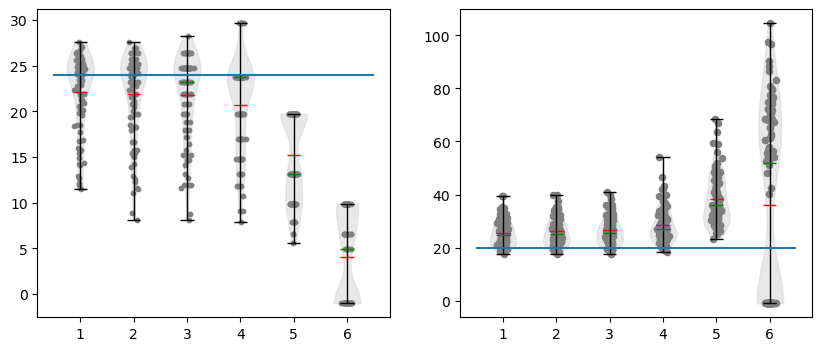

In [50]:
fig, ax = plt.subplots(1,2)

violin = ax[0].violinplot(dataset = [results[results.dt == 0.1]["elongation_r"].values,
                           results[results.dt == 1.0]["elongation_r"].values,
                          results[results.dt == 3.0]["elongation_r"].values,
                          results[results.dt == 10.0]["elongation_r"].values,
                          results[results.dt == 30.0]["elongation_r"].values,
                          results[results.dt == 60.0]["elongation_r"].values,],
                            showmeans=True,
                          showmedians=True)
for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
    


violin = ax[1].violinplot(dataset = [results[results.dt == 0.1]["init_translation_r"].values,
                           results[results.dt == 1.0]["init_translation_r"].values,
                          results[results.dt == 3.0]["init_translation_r"].values,
                          results[results.dt == 10.0]["init_translation_r"].values,
                          results[results.dt == 30.0]["init_translation_r"].values,
                          results[results.dt == 60.0]["init_translation_r"].values,],
                          showmeans=True,
                          showmedians=True)
for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)
colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
    
group = 'dt'
column = 'elongation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[0].scatter(x, val, c='grey', alpha=1, s=10)
    
group = 'dt'
column = 'init_translation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[1].scatter(x, val, c='grey', alpha=1, s=20)
# ax[1].set_ylim(0,0.1)
    
# ax[1].set_ylim(0,250)

ax[0].hlines(24, 0.5, 6.5)
ax[1].hlines(1/0.05, 0.5, 6.5)
fig.set_size_inches((10,4))
fig.savefig(os.path.join(path_save, "results_delta_t_boxplot_linear_diff.eps"), dpi=300)

(0.0, 100.0)

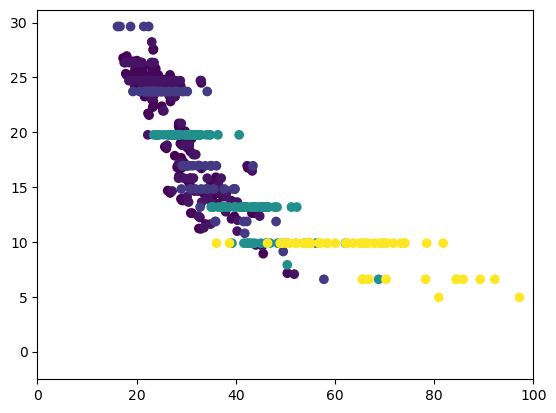

In [10]:
fig, ax = plt.subplots()
ax.scatter(results["init_translation_r"], results["elongation_r"], c=results["dt"])
ax.set_xlim(0,100)

In [11]:
from scipy.stats import bootstrap

d = (results[results.dt == 30]["elongation_r"].to_numpy(),)
bootstrap_ci = bootstrap(d,
                          np.mean, 
                          confidence_level=0.95,
                          method="percentile"
                         )
bootstrap_ci.confidence_interval

ConfidenceInterval(low=14.696166666666668, high=16.455633333333328)

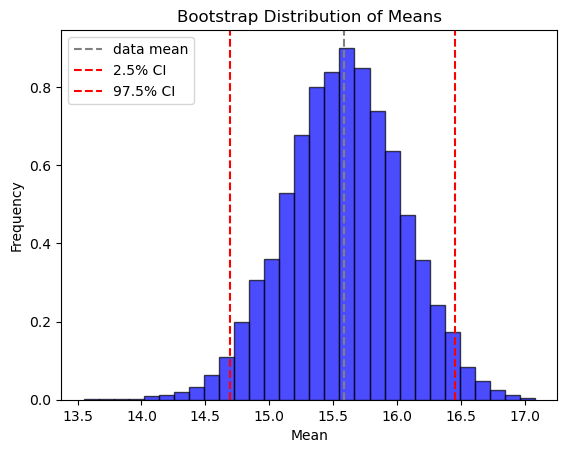

ConfidenceInterval(low=14.696166666666668, high=16.455633333333328)
Bootstrap Mean Estimate: 	15.583806298407618
Bootstrap Median Estimate: 	15.585899999999997
Bootstrap Standard Error: 	0.45371163475131904
Mean: 	15.585899999999997
Bootstrap Bias: -0.0020937015923792046


In [12]:
import matplotlib.pyplot as plt

plt.hist(bootstrap_ci.bootstrap_distribution, density=True, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Bootstrap Distribution of Means')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.axvline(np.mean(d)  , color='grey', linestyle='dashed', label='data mean')
plt.axvline(bootstrap_ci.confidence_interval.low, color='red', linestyle='dashed', label='2.5% CI')
plt.axvline(bootstrap_ci.confidence_interval.high, color='red', linestyle='dashed', label='97.5% CI')
plt.legend()
plt.show()

print(bootstrap_ci.confidence_interval)
# calculate central tendency
mean_estimate = np.mean(bootstrap_ci.bootstrap_distribution)
median_estimate = np.median(bootstrap_ci.bootstrap_distribution)
print(f"Bootstrap Mean Estimate: \t{mean_estimate}")
print(f"Bootstrap Median Estimate: \t{median_estimate}")

# measure variability
standard_error = np.std(bootstrap_ci.bootstrap_distribution)
print(f"Bootstrap Standard Error: \t{standard_error}")

# Assess bias
original_statistic = np.mean(d)  
print(f"Mean: \t{original_statistic}")
bias = np.mean(bootstrap_ci.bootstrap_distribution) - original_statistic
print(f"Bootstrap Bias: {bias}")



In [13]:
result_group = results.groupby(by='dt')[['elongation_r','init_translation_r']].mean()
result_group

,elongation_r,init_translation_r
dt,,
0.1,21.378998,26.816988
1.0,20.943686,27.428859
3.0,20.401166,28.251733
10.0,19.893238,29.871447
30.0,15.585900,37.101840
60.0,4.584028,36.979017


In [14]:
result_group["ratio"] = 100*result_group["elongation_r"]/24
result_group

,elongation_r,init_translation_r,ratio
dt,,,
0.1,21.378998,26.816988,89.079159
1.0,20.943686,27.428859,87.265357
3.0,20.401166,28.251733,85.004857
10.0,19.893238,29.871447,82.888491
30.0,15.585900,37.101840,64.941250
60.0,4.584028,36.979017,19.100116


In [11]:
results[3::100]

,elongation_r,init_translation_r,dt,id
3,23.392505,0.039939,0.1,3
103,22.377358,0.038642,1.0,3
203,23.254902,0.038979,3.0,3
303,23.720000,0.038400,10.0,3
403,19.766667,0.032540,30.0,3
503,9.883333,0.014135,60.0,3


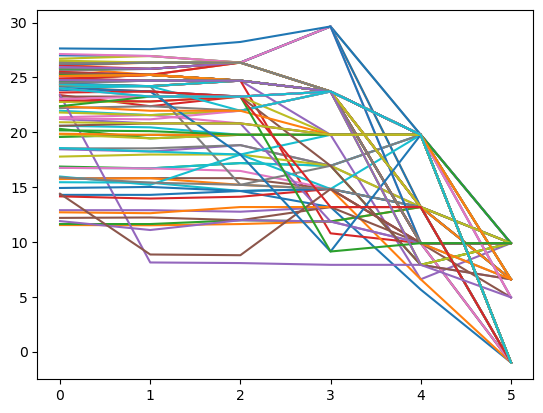

In [12]:
fig, ax = plt.subplots()
for i in range(100):
    ax.plot(range(6), results[i::100]["elongation_r"])

In [13]:
results

,elongation_r,init_translation_r,dt,id
0,24.863732,0.043771,0.1,0
1,26.065934,0.040075,0.1,1
2,19.570957,0.030959,0.1,2
3,23.392505,0.039939,0.1,3
4,25.287846,0.046100,0.1,4
...,...,...,...,...
595,-1.000000,-1.000000,60.0,95
596,-1.000000,-1.000000,60.0,96
597,-1.000000,-1.000000,60.0,97
598,-1.000000,-1.000000,60.0,98


In [9]:
datas[datas["TRACK_ID"]==0][::10]

,Unnamed: 0,FRAME,MEAN_INTENSITY_CH1,TRACK_ID
0,0,0.0,595.6,0
10,10,1.0,607.6,0
20,20,2.0,491.6,0
30,30,3.0,503.6,0
40,40,4.0,515.6,0
...,...,...,...,...
57950,57950,5795.0,5.2,0
57960,57960,5796.0,9.2,0
57970,57970,5797.0,13.2,0
57980,57980,5798.0,17.2,0
